<a href="https://colab.research.google.com/github/We1rdguy/RSNA-Pneumonia-Detection-/blob/master/RSNA_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
! pip install pydicom
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
import os
%matplotlib inline 

     |████████████████████████████████| 7.0MB 681kB/s 


In [0]:
os.listdir()

['stage_2_detailed_class_info.csv',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_sample_submission.csv',
 'stage_2_train_labels.csv',
 'Train_data',
 'Test_data']

In [0]:

dataset_path='gdrive/My Drive/Dataset/RSNA/'
os.chdir(dataset_path)


In [0]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv')

In [0]:
print("Detailed class info -  rows:",class_info_df.shape[0]," columns:", class_info_df.shape[1])
print("Train labels -  rows:",train_labels_df.shape[0]," columns:", train_labels_df.shape[1])


Detailed class info -  rows: 30227  columns: 2
Train labels -  rows: 30227  columns: 6


In [0]:
class_info_df.sample(5)


,patientId,class
16854,a2598429-e7cc-47b9-b537-447a9768bc78,No Lung Opacity / Not Normal
23268,d187294d-3dff-4de1-9bef-90a4f4c76cef,Lung Opacity
18246,ac9106d5-8cbc-46b0-b27e-8c998b04ef51,Lung Opacity
28814,feb8c6c9-932a-481e-a2a1-3989cd1d3e90,No Lung Opacity / Not Normal
20647,bc816a92-976c-41d6-9659-6fc32281231a,Normal


In [0]:
train_labels_df.sample(5)

,patientId,x,y,width,height,Target
20062,b8cf9f96-ccb2-4465-a1ab-386ff38889f9,NaN,NaN,NaN,NaN,0
20741,bcff3700-de7c-42c2-be5d-1c95d008966a,333.0,494.0,127.0,238.0,1
30067,2ef4cfe7-bbc1-4ce2-ba1e-6df54a94252c,295.0,595.0,170.0,135.0,1
20435,bb1648ed-992f-482f-b3a7-0a21237c8972,225.0,442.0,206.0,216.0,1
21133,bf90b850-cae0-4f24-9767-a63923beeaf3,NaN,NaN,NaN,NaN,0


In [0]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train_labels_df)

,Total,Percent
height,20672,68.389188
width,20672,68.389188
y,20672,68.389188
x,20672,68.389188
Target,0,0.000000
patientId,0,0.000000


In [0]:
missing_data(class_info_df)

,Total,Percent
class,0,0.0
patientId,0,0.0


Rectangle(xy=(-0.4, 0), width=0.8, height=11821, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=9555, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=8851, angle=0)


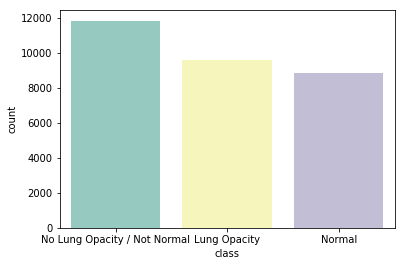

In [0]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],
              order = class_info_df['class'].value_counts().index, 
              palette='Set3')
for p in ax.patches:
  print(p)

In [0]:
class_info_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [0]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    print("Total counts:{}".format(total_samples))
    
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} ({}%)".format(label, count, percent))
    
get_feature_distribution(class_info_df, 'class')

Feature: class
Total counts:30227
No Lung Opacity / Not Normal  :   11821 (39.1%)
Lung Opacity                  :   9555 (31.61%)
Normal                        :   8851 (29.28%)


In [0]:
class_info_df.sample(5)

,patientId,class
19872,b77ab795-de76-4715-b371-eb7be54b584c,Lung Opacity
21371,c2c3e54f-e498-42dc-a9db-4c0179b2c1ce,No Lung Opacity / Not Normal
13961,8b228394-953c-4d88-be6d-3766c37dc4a9,No Lung Opacity / Not Normal
16747,a169b48a-7fbf-45b1-a951-b0f0fc18a261,No Lung Opacity / Not Normal
2774,340e5ce5-5845-4c7d-be4d-a646c7e5c4ed,Normal


In [0]:
train_class_df = train_labels_df.merge(class_info_df,
                                       left_on='patientId',
                                       right_on='patientId',
                                       how='inner')

In [0]:
train_class_df.sample(5)

,patientId,x,y,width,height,Target,class
28550,cb686220-09d7-436f-ac1d-2e753c0330ac,NaN,NaN,NaN,NaN,0,Normal
24268,b4299b1e-7fb8-479d-8754-0a8fa6463400,86.0,232.0,381.0,459.0,1,Lung Opacity
14800,79f29a4d-fa0a-4977-abae-346d8ee33aa9,587.0,538.0,160.0,145.0,1,Lung Opacity
18295,9076de25-6b98-422f-9d11-cca443db24b9,NaN,NaN,NaN,NaN,0,Normal
32107,e6049f73-167c-4a7c-b193-c8574a3097e8,NaN,NaN,NaN,NaN,0,Normal


In [0]:
tmp = train_class_df.groupby('Target')['class'].value_counts()

tmp

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                    16957
Name: class, dtype: int64

<Figure size 432x288 with 0 Axes>

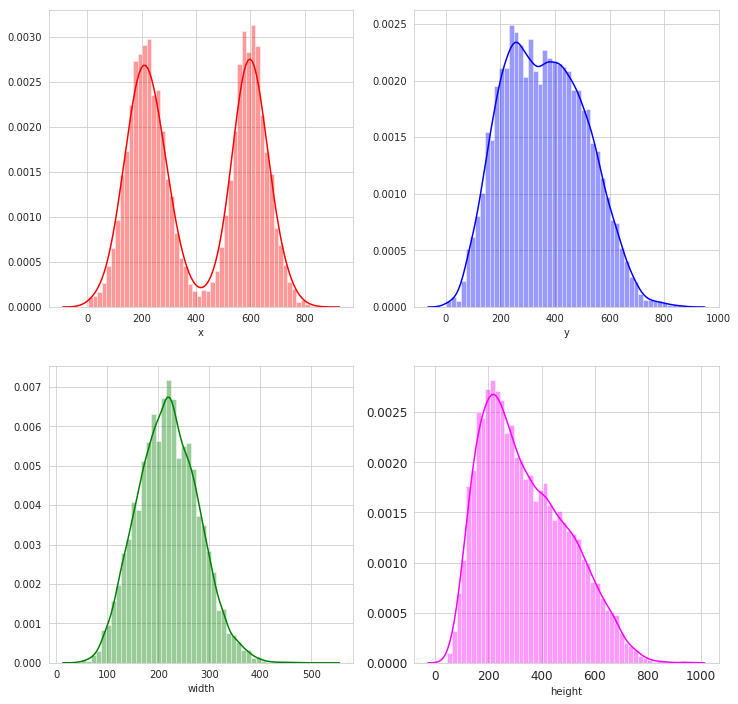

In [0]:
# Detected Lung Opacity window
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()

fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

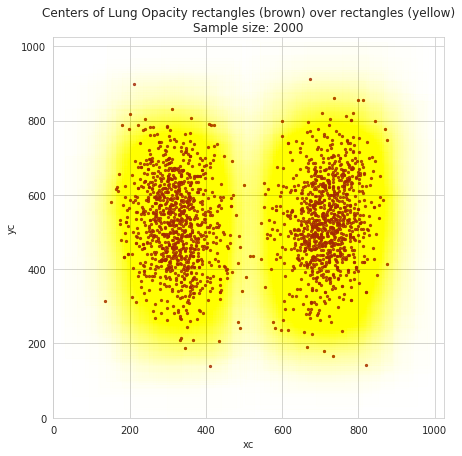

In [0]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc',
                           y='yc',
                           xlim=(0,1024),
                           ylim=(0,1024),
                           ax=ax, alpha=0.8,
                           marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                           width=crt_sample['width'],
                           height=crt_sample['height'],
                           alpha=3.5e-3, color="yellow"))
plt.show()